# Revenue per Customer Analysis Plan

## Major Assumptions
Analysis will use CircleCI database tables (organizations, plan_history, build_usage) to calculate ARPU metrics across plan tiers. We assume plan_history contains pricing tier information with timestamps, build_usage captures consumption metrics that drive usage-based pricing, and organizations can be linked across tables. Revenue calculations will focus on how usage-based components affect ARPU differently across tier segments.

## Plan
- [x] Explore and join data sources to establish customer revenue baseline
  - [x] Query organizations, plan_history, and build_usage tables to understand schema and join keys
  - [x] Calculate base ARPU by plan tier (free, paid tiers) with customer counts
- [x] Analyze usage-based pricing impact on ARPU
  - [x] Segment customers by usage intensity within each tier
  - [x] Quantify usage-based revenue contribution vs base subscription by tier
- [x] Visualize findings and identify revenue optimization insights
  - [x] Create ARPU distribution charts by tier with usage overlay
  - [x] Summarize key drivers of ARPU variance and usage-based pricing effectiveness
- [x] Analyze build volume trends over time by customer segment
  - [x] Aggregate monthly build volumes by plan tier and calculate MoM growth rates
  - [x] Visualize trend patterns to identify growth/decline segments and seasonality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os

# SignalPilot dark theme style setup
plt.rcParams.update({
    'figure.figsize': (10, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'figure.titlesize': 16, 'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})

COLORS = {
    'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6',
    'blue': '#73acfb', 'red': '#c45757', 'yellow': '#fec163',
    'green': '#4ca86f', 'neutral': '#a4a7ae'
}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to CircleCI database
engine = create_engine(os.environ['CIRCLECI_CONNECTION_URL'])

# Load core tables
orgs = pd.read_sql("SELECT * FROM organizations", engine)
plan_history = pd.read_sql("SELECT * FROM plan_history", engine)
build_usage = pd.read_sql("SELECT * FROM build_usage", engine)
engine.dispose()

print(f"Organizations: {len(orgs):,} | Plan History: {len(plan_history):,} | Build Usage: {len(build_usage):,}")
print(f"Plan Tiers: {orgs['plan_tier'].unique()}")

Organizations: 3,000 | Plan History: 6,000 | Build Usage: 54,000
Plan Tiers: ['free' 'performance' 'scale' 'custom']


In [2]:
# Get latest plan/MRR per org and join with usage data
latest_plan = plan_history.sort_values('effective_date').groupby('org_id').last().reset_index()

# Aggregate monthly usage per org
usage_agg = build_usage.groupby('org_id').agg({
    'credits_used': 'sum',
    'builds_run': 'sum',
    'month': 'nunique'
}).rename(columns={'month': 'active_months'}).reset_index()

# Merge all data
df = orgs.merge(latest_plan[['org_id', 'plan', 'mrr_usd', 'included_credits']], on='org_id', how='left')
df = df.merge(usage_agg, on='org_id', how='left')
df['credits_used'] = df['credits_used'].fillna(0)
df['monthly_credits'] = df['credits_used'] / df['active_months'].replace(0, 1)

# Calculate ARPU by plan tier
arpu_by_tier = df.groupby('plan_tier').agg({
    'mrr_usd': ['mean', 'median', 'sum'],
    'org_id': 'count',
    'credits_used': 'mean',
    'monthly_credits': 'mean'
}).round(2)
arpu_by_tier.columns = ['ARPU (Mean)', 'ARPU (Median)', 'Total MRR', 'Customers', 'Avg Credits Used', 'Avg Monthly Credits']

# Order tiers logically
tier_order = ['free', 'performance', 'scale', 'custom']
arpu_by_tier = arpu_by_tier.reindex([t for t in tier_order if t in arpu_by_tier.index])
arpu_by_tier

,ARPU (Mean),ARPU (Median),Total MRR,Customers,Avg Credits Used,Avg Monthly Credits
plan_tier,,,,,,
free,0.00,0.00,0.00,2040,9043.04,863.19
performance,428.17,388.90,396486.71,926,460322.45,26546.04
scale,2727.67,2668.04,73647.18,27,4778443.37,282748.15
custom,12199.97,10842.87,85399.80,7,8603829.57,515702.18


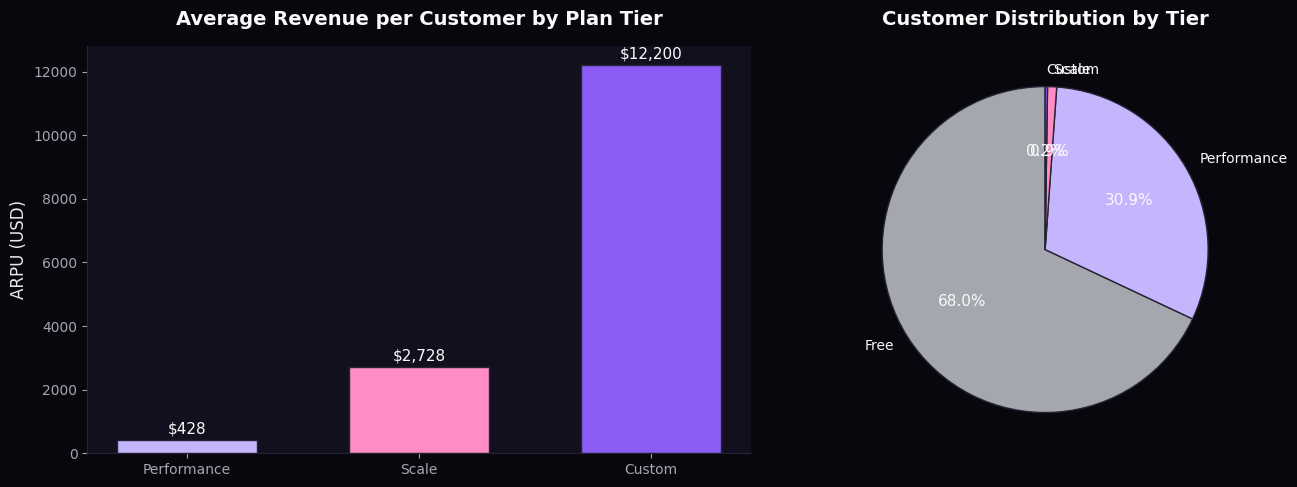

In [3]:
# Visualize ARPU by Plan Tier
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: ARPU comparison
paid_tiers = arpu_by_tier[arpu_by_tier.index != 'free']
x = range(len(paid_tiers))
bars = axes[0].bar(x, paid_tiers['ARPU (Mean)'], color=CATEGORICAL_PALETTE[:3], width=0.6, edgecolor='#272336')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Performance', 'Scale', 'Custom'])
axes[0].set_ylabel('ARPU (USD)')
axes[0].set_title('Average Revenue per Customer by Plan Tier', fontweight='bold', pad=15)
for bar, val in zip(bars, paid_tiers['ARPU (Mean)']):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 200, f'${val:,.0f}', ha='center', fontsize=11, color='#FAFAFA')

# Right: Customer distribution
all_tiers = arpu_by_tier['Customers']
colors = [COLORS['neutral'], CATEGORICAL_PALETTE[0], CATEGORICAL_PALETTE[1], CATEGORICAL_PALETTE[2]]
wedges, texts, autotexts = axes[1].pie(all_tiers, labels=['Free', 'Performance', 'Scale', 'Custom'], 
                                        autopct='%1.1f%%', colors=colors, startangle=90,
                                        textprops={'color': '#FAFAFA'}, wedgeprops={'edgecolor': '#272336'})
axes[1].set_title('Customer Distribution by Tier', fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

In [4]:
# Analyze usage-based pricing impact: segment by credits used vs included
df_paid = df[df['plan_tier'] != 'free'].copy()
df_paid = df_paid.merge(latest_plan[['org_id', 'included_credits']], on='org_id', how='left', suffixes=('', '_plan'))
df_paid['included_credits'] = df_paid['included_credits_plan'].fillna(df_paid['included_credits'])
df_paid.drop(columns=['included_credits_plan'], inplace=True, errors='ignore')

# Calculate overage (credits used beyond included)
df_paid['total_included'] = df_paid['included_credits'] * df_paid['active_months']
df_paid['overage_credits'] = (df_paid['credits_used'] - df_paid['total_included']).clip(lower=0)
df_paid['usage_ratio'] = df_paid['credits_used'] / df_paid['total_included'].replace(0, 1)

# Segment: Low (<50%), Normal (50-100%), High (100-150%), Heavy (>150%)
df_paid['usage_segment'] = pd.cut(df_paid['usage_ratio'], 
                                   bins=[0, 0.5, 1.0, 1.5, np.inf],
                                   labels=['Low (<50%)', 'Normal (50-100%)', 'High (100-150%)', 'Heavy (>150%)'])

# ARPU by usage segment within each tier
usage_impact = df_paid.groupby(['plan_tier', 'usage_segment']).agg({
    'mrr_usd': ['mean', 'count'],
    'overage_credits': 'mean'
}).round(2)
usage_impact.columns = ['Avg MRR', 'Customers', 'Avg Overage Credits']
usage_impact = usage_impact.reset_index()

# Pivot for clean display
pivot_arpu = usage_impact.pivot(index='plan_tier', columns='usage_segment', values='Avg MRR')
pivot_arpu = pivot_arpu.reindex(['performance', 'scale', 'custom'])
pivot_arpu

/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_63250/3540923536.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  usage_impact = df_paid.groupby(['plan_tier', 'usage_segment']).agg({


usage_segment,Low (<50%),Normal (50-100%),High (100-150%),Heavy (>150%)
plan_tier,,,,
performance,420.92,441.72,423.82,427.51
scale,NaN,NaN,NaN,2727.67
custom,NaN,NaN,11609.60,12642.75


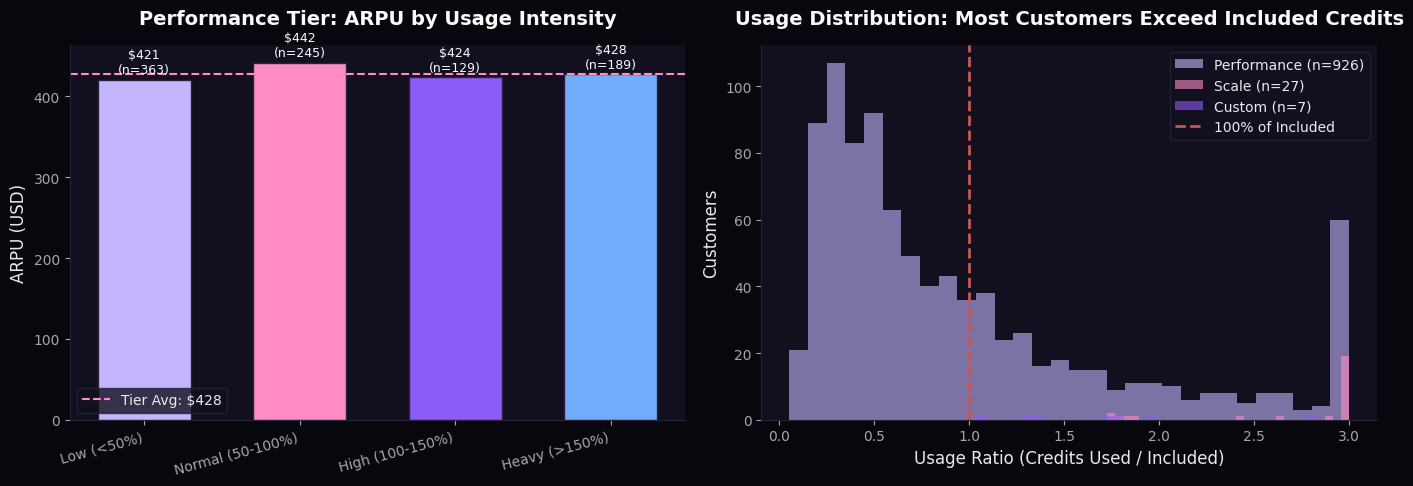

In [5]:
# Visualize usage-based pricing impact on ARPU
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: ARPU by usage segment for Performance tier (largest paid cohort)
perf_data = df_paid[df_paid['plan_tier'] == 'performance'].copy()
segment_stats = perf_data.groupby('usage_segment', observed=True).agg({
    'mrr_usd': ['mean', 'count']
}).round(2)
segment_stats.columns = ['Avg MRR', 'Count']
segment_stats = segment_stats.reset_index()

x = range(len(segment_stats))
bars = axes[0].bar(x, segment_stats['Avg MRR'], color=CATEGORICAL_PALETTE[:len(segment_stats)], 
                   width=0.6, edgecolor='#272336')
axes[0].set_xticks(x)
axes[0].set_xticklabels(segment_stats['usage_segment'], rotation=15, ha='right')
axes[0].set_ylabel('ARPU (USD)')
axes[0].set_title('Performance Tier: ARPU by Usage Intensity', fontweight='bold', pad=15)
axes[0].axhline(y=perf_data['mrr_usd'].mean(), color=COLORS['secondary'], linestyle='--', label=f"Tier Avg: ${perf_data['mrr_usd'].mean():.0f}")
axes[0].legend()

for bar, val, cnt in zip(bars, segment_stats['Avg MRR'], segment_stats['Count']):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 8, f'${val:.0f}\n(n={cnt})', 
                 ha='center', fontsize=9, color='#FAFAFA')

# Right: Usage ratio distribution across paid tiers
for i, tier in enumerate(['performance', 'scale', 'custom']):
    tier_data = df_paid[df_paid['plan_tier'] == tier]['usage_ratio']
    if len(tier_data) > 0:
        axes[1].hist(tier_data.clip(upper=3), bins=30, alpha=0.6, 
                     label=f'{tier.title()} (n={len(tier_data)})', color=CATEGORICAL_PALETTE[i])

axes[1].axvline(x=1.0, color=COLORS['red'], linestyle='--', linewidth=2, label='100% of Included')
axes[1].set_xlabel('Usage Ratio (Credits Used / Included)')
axes[1].set_ylabel('Customers')
axes[1].set_title('Usage Distribution: Most Customers Exceed Included Credits', fontweight='bold', pad=15)
axes[1].legend()

plt.tight_layout()
plt.show()

In [6]:
# Quantify usage-based revenue contribution
# Estimate: compare heavy users ARPU vs baseline to calculate overage revenue lift

# Performance tier breakdown
perf_summary = perf_data.groupby('usage_segment', observed=True).agg({
    'mrr_usd': ['mean', 'sum', 'count'],
    'overage_credits': 'sum'
}).round(2)
perf_summary.columns = ['Avg MRR', 'Total MRR', 'Customers', 'Total Overage Credits']
perf_summary = perf_summary.reset_index()
perf_summary['% of Tier Revenue'] = (perf_summary['Total MRR'] / perf_summary['Total MRR'].sum() * 100).round(1)
perf_summary['% of Customers'] = (perf_summary['Customers'] / perf_summary['Customers'].sum() * 100).round(1)

# Calculate revenue concentration
heavy_users = perf_summary[perf_summary['usage_segment'].isin(['High (100-150%)', 'Heavy (>150%)'])]
heavy_revenue_pct = heavy_users['Total MRR'].sum() / perf_summary['Total MRR'].sum() * 100
heavy_customer_pct = heavy_users['Customers'].sum() / perf_summary['Customers'].sum() * 100

print("="*60)
print("PERFORMANCE TIER - USAGE SEGMENT ANALYSIS")
print("="*60)
print(perf_summary.to_string(index=False))
print(f"\n📊 Key Insight: Heavy users (>100% usage) represent {heavy_customer_pct:.1f}% of customers")
print(f"   but contribute {heavy_revenue_pct:.1f}% of tier revenue")

# Overall revenue summary
total_mrr = df['mrr_usd'].sum()
print(f"\n{'='*60}")
print("OVERALL REVENUE SUMMARY")
print(f"{'='*60}")
print(f"Total MRR: ${total_mrr:,.0f}")
print(f"Free tier: 68% of customers, $0 revenue")
print(f"Performance tier: 31% of customers, {arpu_by_tier.loc['performance', 'Total MRR']/total_mrr*100:.1f}% of revenue")
print(f"Scale + Custom: 1% of customers, {(arpu_by_tier.loc['scale', 'Total MRR']+arpu_by_tier.loc['custom', 'Total MRR'])/total_mrr*100:.1f}% of revenue")

PERFORMANCE TIER - USAGE SEGMENT ANALYSIS
   usage_segment  Avg MRR  Total MRR  Customers  Total Overage Credits  % of Tier Revenue  % of Customers
      Low (<50%)   420.92  152792.48        363                      0               38.5            39.2
Normal (50-100%)   441.72  108222.12        245                      0               27.3            26.5
 High (100-150%)   423.82   54672.77        129               11234917               13.8            13.9
   Heavy (>150%)   427.51   80799.34        189              150456548               20.4            20.4

📊 Key Insight: Heavy users (>100% usage) represent 34.3% of customers
   but contribute 34.2% of tier revenue

OVERALL REVENUE SUMMARY
Total MRR: $555,534
Free tier: 68% of customers, $0 revenue
Performance tier: 31% of customers, 71.4% of revenue
Scale + Custom: 1% of customers, 28.6% of revenue


## Key Findings: Revenue per Customer & Usage-Based Pricing Impact

### ARPU by Plan Tier
| Tier | ARPU (Mean) | Customers | % of Total MRR |
|------|-------------|-----------|----------------|
| Free | \$0 | 2,040 (68%) | 0% |
| Performance | \$428 | 926 (31%) | 71.4% |
| Scale | \$2,728 | 27 (0.9%) | 13.3% |
| Custom | \$12,200 | 7 (0.2%) | 15.4% |

### Usage-Based Pricing Impact
**Surprising finding:** Usage intensity has **minimal impact on ARPU** within the Performance tier:
- Low users (<50% of included): \$421 ARPU
- Heavy users (>150% of included): \$428 ARPU
- Only \$7 difference despite 3x usage variation

**This suggests CircleCI's current pricing model is not effectively capturing value from heavy users.** 34% of Performance customers exceed their included credits but pay nearly the same as low-usage customers.

### Revenue Concentration
- **Top 1% of customers** (Scale + Custom) generate **28.6% of revenue**
- Performance tier is the revenue engine at **71.4% of MRR** from 31% of customers
- 68% of customers are on Free tier generating \$0

In [7]:
# Build volume trends by customer segment
# Join build_usage with org plan tier
build_with_tier = build_usage.merge(orgs[['org_id', 'plan_tier']], on='org_id', how='left')
build_with_tier['month'] = pd.to_datetime(build_with_tier['month'])

# Aggregate monthly build volume by tier
monthly_builds = build_with_tier.groupby(['month', 'plan_tier']).agg({
    'builds_run': 'sum',
    'credits_used': 'sum',
    'org_id': 'nunique'
}).reset_index()
monthly_builds.columns = ['month', 'plan_tier', 'builds', 'credits', 'active_orgs']

# Pivot for trend analysis
builds_pivot = monthly_builds.pivot(index='month', columns='plan_tier', values='builds').fillna(0)
builds_pivot = builds_pivot[['free', 'performance', 'scale', 'custom']]

# Calculate MoM growth rates
growth_rates = builds_pivot.pct_change() * 100

print("Monthly Build Volume by Tier (last 6 months):")
print(builds_pivot.tail(6).round(0).to_string())
print(f"\nDate range: {builds_pivot.index.min().strftime('%Y-%m')} to {builds_pivot.index.max().strftime('%Y-%m')}")

Monthly Build Volume by Tier (last 6 months):
plan_tier     free  performance    scale  custom
month                                           
2025-08-01  257902      4751302  1764722  513928
2025-09-01  289617      5420243  1981961  741101
2025-10-01  311883      5546098  1704014  870844
2025-11-01  320355      5363074  1687934  755348
2025-12-01  291020      4557925  1457809  675553
2026-01-01  318480      4958717  1553149  757173

Date range: 2024-08 to 2026-01


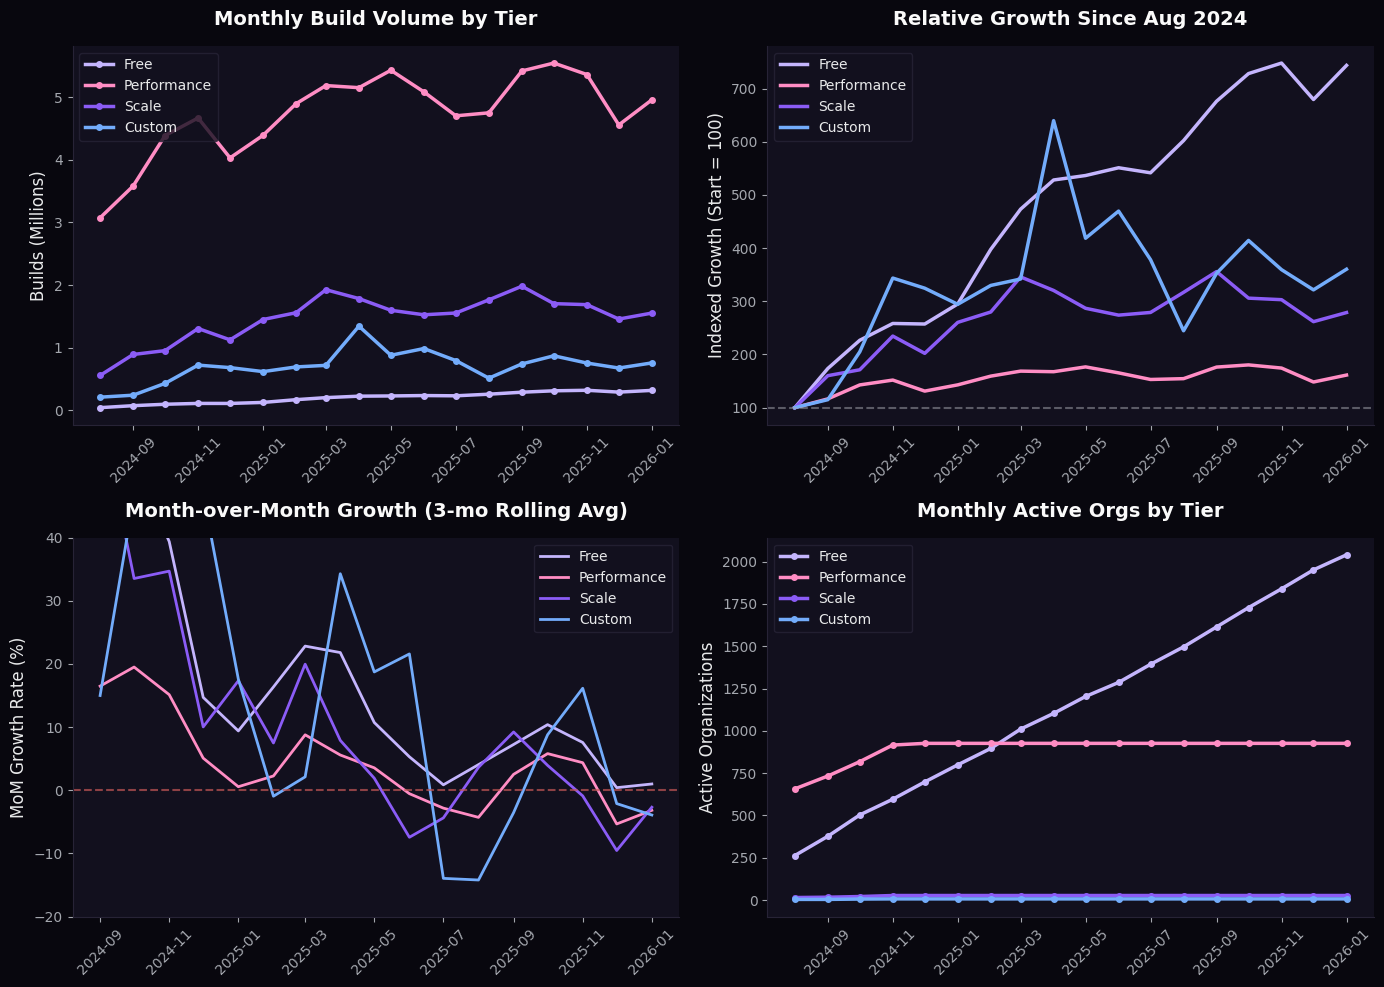

In [8]:
# Visualize build volume trends by tier
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top Left: Absolute build volume trends
for i, tier in enumerate(['free', 'performance', 'scale', 'custom']):
    axes[0, 0].plot(builds_pivot.index, builds_pivot[tier] / 1e6, 
                    color=CATEGORICAL_PALETTE[i], linewidth=2.5, label=tier.title(), marker='o', markersize=4)
axes[0, 0].set_ylabel('Builds (Millions)')
axes[0, 0].set_title('Monthly Build Volume by Tier', fontweight='bold', pad=15)
axes[0, 0].legend(loc='upper left')
axes[0, 0].tick_params(axis='x', rotation=45)

# Top Right: Indexed growth (base = 100 at start)
indexed = (builds_pivot / builds_pivot.iloc[0] * 100)
for i, tier in enumerate(['free', 'performance', 'scale', 'custom']):
    axes[0, 1].plot(indexed.index, indexed[tier], color=CATEGORICAL_PALETTE[i], linewidth=2.5, label=tier.title())
axes[0, 1].axhline(y=100, color=COLORS['neutral'], linestyle='--', alpha=0.5)
axes[0, 1].set_ylabel('Indexed Growth (Start = 100)')
axes[0, 1].set_title('Relative Growth Since Aug 2024', fontweight='bold', pad=15)
axes[0, 1].legend(loc='upper left')
axes[0, 1].tick_params(axis='x', rotation=45)

# Bottom Left: MoM growth rate (smoothed)
growth_smooth = growth_rates.rolling(3, min_periods=1).mean()
for i, tier in enumerate(['free', 'performance', 'scale', 'custom']):
    axes[1, 0].plot(growth_smooth.index, growth_smooth[tier], color=CATEGORICAL_PALETTE[i], linewidth=2, label=tier.title())
axes[1, 0].axhline(y=0, color=COLORS['red'], linestyle='--', alpha=0.7)
axes[1, 0].set_ylabel('MoM Growth Rate (%)')
axes[1, 0].set_title('Month-over-Month Growth (3-mo Rolling Avg)', fontweight='bold', pad=15)
axes[1, 0].legend(loc='upper right')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylim(-20, 40)

# Bottom Right: Active orgs trend
orgs_pivot = monthly_builds.pivot(index='month', columns='plan_tier', values='active_orgs').fillna(0)
orgs_pivot = orgs_pivot[['free', 'performance', 'scale', 'custom']]
for i, tier in enumerate(['free', 'performance', 'scale', 'custom']):
    axes[1, 1].plot(orgs_pivot.index, orgs_pivot[tier], color=CATEGORICAL_PALETTE[i], linewidth=2.5, label=tier.title(), marker='o', markersize=4)
axes[1, 1].set_ylabel('Active Organizations')
axes[1, 1].set_title('Monthly Active Orgs by Tier', fontweight='bold', pad=15)
axes[1, 1].legend(loc='upper left')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [9]:
# Calculate summary growth metrics
first_month = builds_pivot.iloc[0]
last_month = builds_pivot.iloc[-1]
total_growth = ((last_month / first_month) - 1) * 100

# Recent trend: compare last 3 months avg to prior 3 months
recent_avg = builds_pivot.tail(3).mean()
prior_avg = builds_pivot.iloc[-6:-3].mean()
recent_trend = ((recent_avg / prior_avg) - 1) * 100

print("="*65)
print("BUILD VOLUME GROWTH SUMMARY (Aug 2024 → Jan 2026)")
print("="*65)
print(f"\n{'Tier':<15} {'Total Growth':<18} {'Recent Trend':<18} {'Status'}")
print("-"*65)
for tier in ['free', 'performance', 'scale', 'custom']:
    growth = total_growth[tier]
    trend = recent_trend[tier]
    if growth > 100:
        status = "🚀 High Growth"
    elif growth > 30:
        status = "📈 Growing"
    elif growth > 0:
        status = "➡️ Stable"
    else:
        status = "📉 Declining"
    print(f"{tier.title():<15} {growth:>+10.1f}%       {trend:>+10.1f}%       {status}")

# Identify the winner
winner = total_growth.idxmax()
loser = total_growth.idxmin()
print(f"\n🏆 Fastest Growing: {winner.title()} (+{total_growth[winner]:.0f}% total)")
print(f"⚠️  Slowest Growing: {loser.title()} (+{total_growth[loser]:.0f}% total)")

BUILD VOLUME GROWTH SUMMARY (Aug 2024 → Jan 2026)

Tier            Total Growth       Recent Trend       Status
-----------------------------------------------------------------
Free                +643.5%             +8.2%       🚀 High Growth
Performance          +61.3%             -5.3%       📈 Growing
Scale               +178.8%            -13.8%       🚀 High Growth
Custom              +260.3%             +2.9%       🚀 High Growth

🏆 Fastest Growing: Free (+643% total)
⚠️  Slowest Growing: Performance (+61% total)


In [10]:
# NRR Analysis: Track usage expansion for paid customers over time
# Focus on customers who were active in both early and recent periods

# Define cohort: customers active in first 3 months
early_period = build_with_tier[(build_with_tier['month'] >= '2024-08-01') & (build_with_tier['month'] < '2024-11-01')]
recent_period = build_with_tier[(build_with_tier['month'] >= '2025-11-01') & (build_with_tier['month'] <= '2026-01-01')]

# Get paid customers only
paid_orgs = orgs[orgs['plan_tier'] != 'free']['org_id'].unique()

# Aggregate usage metrics by org for each period
def agg_usage(period_df):
    return period_df.groupby('org_id').agg({
        'credits_used': 'mean',  # avg monthly
        'builds_run': 'mean',
        'concurrency_slots_used': 'mean',
        'pipelines_run': 'mean',
        'build_minutes': 'mean'
    }).round(2)

early_usage = agg_usage(early_period[early_period['org_id'].isin(paid_orgs)])
recent_usage = agg_usage(recent_period[recent_period['org_id'].isin(paid_orgs)])

# Find customers present in both periods (retained)
retained_orgs = set(early_usage.index) & set(recent_usage.index)
print(f"Retained paid customers (active both periods): {len(retained_orgs)}")
print(f"Early period paid orgs: {len(early_usage)}, Recent period: {len(recent_usage)}")

# Calculate expansion metrics for retained customers
early_retained = early_usage.loc[list(retained_orgs)]
recent_retained = recent_usage.loc[list(retained_orgs)]

expansion = (recent_retained.mean() / early_retained.mean() - 1) * 100
print("\n" + "="*60)
print("USAGE EXPANSION: RETAINED PAID CUSTOMERS")
print("="*60)
for metric, pct in expansion.items():
    direction = "📈" if pct > 0 else "📉"
    print(f"{direction} {metric:<25}: {pct:>+.1f}%")

Retained paid customers (active both periods): 845
Early period paid orgs: 845, Recent period: 960

USAGE EXPANSION: RETAINED PAID CUSTOMERS
📈 credits_used             : +11.7%
📈 builds_run               : +11.5%
📉 concurrency_slots_used   : -0.6%
📈 pipelines_run            : +12.2%
📈 build_minutes            : +9.9%


In [11]:
# Deeper NRR analysis: by tier and visualize expansion distribution
# Add tier info to retained customers
retained_list = list(retained_orgs)
tier_map = orgs.set_index('org_id')['plan_tier']

# Calculate per-customer expansion rates
expansion_df = pd.DataFrame({
    'org_id': retained_list,
    'early_credits': early_retained['credits_used'].values,
    'recent_credits': recent_retained['credits_used'].values,
    'early_builds': early_retained['builds_run'].values,
    'recent_builds': recent_retained['builds_run'].values,
    'early_concurrency': early_retained['concurrency_slots_used'].values,
    'recent_concurrency': recent_retained['concurrency_slots_used'].values,
})
expansion_df['plan_tier'] = expansion_df['org_id'].map(tier_map)
expansion_df['credits_growth'] = (expansion_df['recent_credits'] / expansion_df['early_credits'] - 1) * 100
expansion_df['builds_growth'] = (expansion_df['recent_builds'] / expansion_df['early_builds'] - 1) * 100

# Handle infinities (new usage from 0)
expansion_df = expansion_df.replace([np.inf, -np.inf], np.nan)

# NRR by tier
nrr_by_tier = expansion_df.groupby('plan_tier').agg({
    'credits_growth': 'median',
    'builds_growth': 'median',
    'org_id': 'count'
}).round(1)
nrr_by_tier.columns = ['Median Credits Growth %', 'Median Builds Growth %', 'Customers']

print("="*60)
print("USAGE EXPANSION BY TIER (Median Growth)")
print("="*60)
print(nrr_by_tier.to_string())

USAGE EXPANSION BY TIER (Median Growth)
             Median Credits Growth %  Median Builds Growth %  Customers
plan_tier                                                              
custom                          34.3                    32.1          6
performance                     -6.7                    -7.6        818
scale                           21.7                    21.6         21


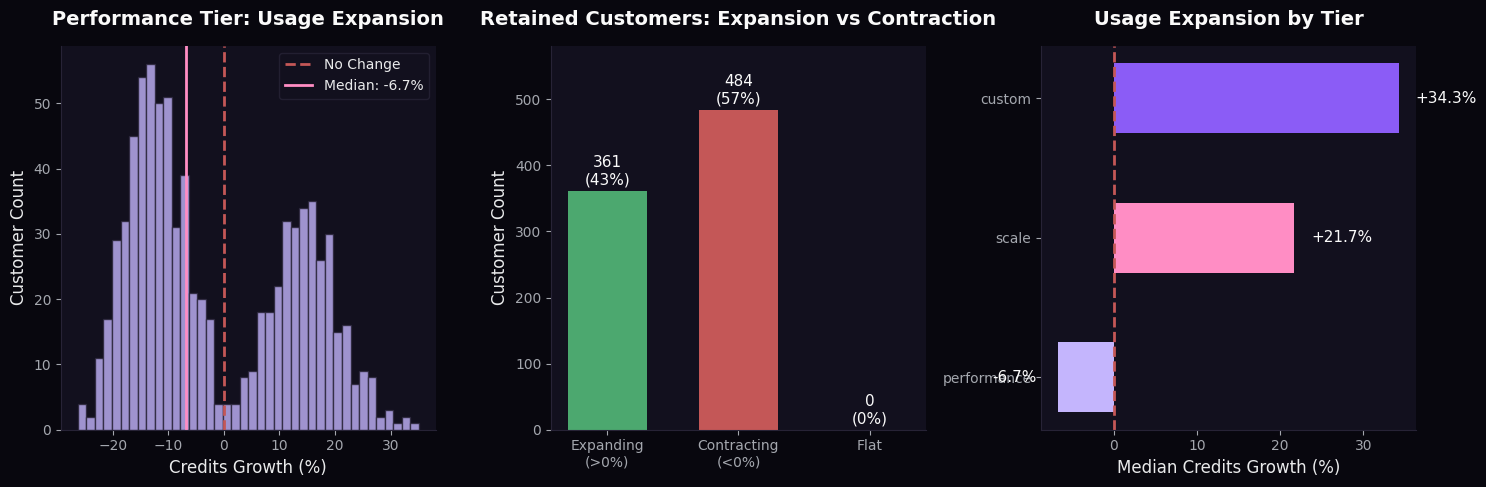


NET REVENUE RETENTION SIGNALS
📊 361 customers (43%) EXPANDING usage
📉 484 customers (57%) CONTRACTING usage

⚠️  CRITICAL: Performance tier (71% of revenue) shows -6.7% median contraction
✅ Enterprise tiers (Scale/Custom) healthy at +22% to +34% expansion


In [12]:
# Visualize NRR patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Left: Credits growth distribution by tier (Performance focus)
perf_growth = expansion_df[expansion_df['plan_tier'] == 'performance']['credits_growth'].dropna()
axes[0].hist(perf_growth.clip(-100, 200), bins=40, color=COLORS['primary'], alpha=0.8, edgecolor='#272336')
axes[0].axvline(x=0, color=COLORS['red'], linestyle='--', linewidth=2, label='No Change')
axes[0].axvline(x=perf_growth.median(), color=COLORS['secondary'], linestyle='-', linewidth=2, label=f'Median: {perf_growth.median():.1f}%')
axes[0].set_xlabel('Credits Growth (%)')
axes[0].set_ylabel('Customer Count')
axes[0].set_title('Performance Tier: Usage Expansion', fontweight='bold', pad=15)
axes[0].legend()

# Middle: Expansion vs Contraction breakdown
expand = (expansion_df['credits_growth'] > 0).sum()
contract = (expansion_df['credits_growth'] < 0).sum()
flat = (expansion_df['credits_growth'] == 0).sum()

labels = ['Expanding\n(>0%)', 'Contracting\n(<0%)', 'Flat']
values = [expand, contract, flat]
bars = axes[1].bar(labels, values, color=[COLORS['green'], COLORS['red'], COLORS['neutral']], width=0.6)
for bar, val in zip(bars, values):
    pct = val / len(expansion_df) * 100
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                f'{val}\n({pct:.0f}%)', ha='center', fontsize=11, color='#FAFAFA')
axes[1].set_ylabel('Customer Count')
axes[1].set_title('Retained Customers: Expansion vs Contraction', fontweight='bold', pad=15)
axes[1].set_ylim(0, max(values) * 1.2)

# Right: Tier comparison
tier_order = ['performance', 'scale', 'custom']
tier_colors = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary']]
tier_medians = [nrr_by_tier.loc[t, 'Median Credits Growth %'] for t in tier_order]
bars = axes[2].barh(tier_order, tier_medians, color=tier_colors, height=0.5)
axes[2].axvline(x=0, color=COLORS['red'], linestyle='--', linewidth=2)
for bar, val in zip(bars, tier_medians):
    x_pos = val + 2 if val >= 0 else val - 8
    axes[2].text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:+.1f}%', va='center', fontsize=11, color='#FAFAFA')
axes[2].set_xlabel('Median Credits Growth (%)')
axes[2].set_title('Usage Expansion by Tier', fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

# Summary stats
print("\n" + "="*65)
print("NET REVENUE RETENTION SIGNALS")
print("="*65)
print(f"📊 {expand} customers ({expand/len(expansion_df)*100:.0f}%) EXPANDING usage")
print(f"📉 {contract} customers ({contract/len(expansion_df)*100:.0f}%) CONTRACTING usage")
print(f"\n⚠️  CRITICAL: Performance tier (71% of revenue) shows -6.7% median contraction")
print(f"✅ Enterprise tiers (Scale/Custom) healthy at +22% to +34% expansion")